# **VGG16 V1**

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: []


In [3]:
DATA_DIR = '../Data'  # Root directory containing Benign and Malignant foldersData
MODEL_SAVE_PATH = 'New_Cancer/Models/vgg16_cancer_classifier.h5'
CHECKPOINT_PATH = 'New_Cancer/Models/vgg16_best_model.h5'
DATA_DIR

'../Data'

In [4]:
# Model Hyperparameters
IMG_HEIGHT = 224  # VGG16 standard input
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2

# Class names (binary classification)
CLASS_NAMES = ['Benign', 'Malignant']
NUM_CLASSES = 1  # Binary classification with sigmoid

print(f"\nConfiguration:")
print(f"  Image Size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Validation Split: {VALIDATION_SPLIT}")


Configuration:
  Image Size: 224x224x3
  Batch Size: 32
  Epochs: 20
  Learning Rate: 0.0001
  Validation Split: 0.2


In [5]:
# Data Loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"\nDataset Information:")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Total samples: {train_generator.samples + validation_generator.samples}")
print(f"  Class indices: {train_generator.class_indices}")
print(f"  Steps per epoch (train): {len(train_generator)}")
print(f"  Validation steps: {len(validation_generator)}")

Found 52002 images belonging to 2 classes.
Found 13000 images belonging to 2 classes.

Dataset Information:
  Training samples: 52002
  Validation samples: 13000
  Total samples: 65002
  Class indices: {'Benign': 0, 'Malignant': 1}
  Steps per epoch (train): 1626
  Validation steps: 407


In [6]:
# Load pre-trained VGG16 model (ImageNet weights)
base_model = VGG16(
    weights='imagenet',
    include_top=False,  # Exclude the top classification layer
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
)

# Freeze the base model layers (transfer learning)
base_model.trainable = False

print(f"  Base Model: VGG16")
print(f"  Pre-trained weights: ImageNet")
print(f"  Trainable: {base_model.trainable}")
print(f"  Total layers in base model: {len(base_model.layers)}")

# Build the complete model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', name='output')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

print(f"\nModel Architecture Summary:")
print(f"  Base: VGG16 (frozen)")
print(f"  GlobalAveragePooling2D")
print(f"  Dense(512) + ReLU + Dropout(0.5)")
print(f"  Dense(256) + ReLU + Dropout(0.3)")
print(f"  Dense(1) + Sigmoid (binary output)")

  Base Model: VGG16
  Pre-trained weights: ImageNet
  Trainable: False
  Total layers in base model: 19

Model Architecture Summary:
  Base: VGG16 (frozen)
  GlobalAveragePooling2D
  Dense(512) + ReLU + Dropout(0.5)
  Dense(256) + ReLU + Dropout(0.3)
  Dense(1) + Sigmoid (binary output)


In [7]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: Binary Crossentropy")
print(f"  Metrics: Accuracy, Precision, Recall, AUC")

# Display model summary
print("\nDetailed Model Summary:")
model.summary()

  Optimizer: Adam (lr=0.0001)
  Loss: Binary Crossentropy
  Metrics: Accuracy, Precision, Recall, AUC

Detailed Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint to save best model
checkpoint = ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print(f"  Early Stopping: patience=5, monitor=val_loss")
print(f"  ReduceLROnPlateau: factor=0.5, patience=5")
print(f"  ModelCheckpoint: saving best model to {CHECKPOINT_PATH}")

  Early Stopping: patience=5, monitor=val_loss
  ReduceLROnPlateau: factor=0.5, patience=5
  ModelCheckpoint: saving best model to New_Cancer/Models/vgg16_best_model.h5


In [9]:
print("\nStarting Training...")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("TRAINING COMPLETED!")



Starting Training...
Epoch 1/20


c:\Users\revna\Desktop\Colab Projects\Cancer_Classification\can_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7641 - auc: 0.8333 - loss: 0.4622 - precision: 0.7765 - recall: 0.8713
Epoch 1: val_accuracy improved from -inf to 0.61508, saving model to New_Cancer/Models/vgg16_best_model.h5


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 5867s 4s/step - accuracy: 0.7641 - auc: 0.8333 - loss: 0.4622 - precision: 0.7766 - recall: 0.8714 - val_accuracy: 0.6151 - val_auc: 0.6790 - val_loss: 1.8284 - val_precision: 0.6155 - val_recall: 0.9976 - learning_rate: 1.0000e-04
Epoch 2/20
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9010 - auc: 0.9678 - loss: 0.2254 - precision: 0.9164 - recall: 0.9237
Epoch 2: val_accuracy improved from 0.61508 to 0.61515, saving model to New_Cancer/Models/vgg16_best_model.h5


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 7083s 4s/step - accuracy: 0.9010 - auc: 0.9678 - loss: 0.2254 - precision: 0.9164 - recall: 0.9237 - val_accuracy: 0.6152 - val_auc: 0.6004 - val_loss: 2.5708 - val_precision: 0.6155 - val_recall: 0.9984 - learning_rate: 1.0000e-04
Epoch 3/20
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9220 - auc: 0.9793 - loss: 0.1801 - precision: 0.9368 - recall: 0.9369
Epoch 3: val_accuracy improved from 0.61515 to 0.61592, saving model to New_Cancer/Models/vgg16_best_model.h5


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 5605s 3s/step - accuracy: 0.9220 - auc: 0.9793 - loss: 0.1801 - precision: 0.9368 - recall: 0.9369 - val_accuracy: 0.6159 - val_auc: 0.6085 - val_loss: 2.7418 - val_precision: 0.6160 - val_recall: 0.9979 - learning_rate: 1.0000e-04
Epoch 4/20
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9303 - auc: 0.9837 - loss: 0.1597 - precision: 0.9460 - recall: 0.9405
Epoch 4: val_accuracy improved from 0.61592 to 0.61615, saving model to New_Cancer/Models/vgg16_best_model.h5


1626/1626 ━━━━━━━━━━━━━━━━━━━━ 5183s 3s/step - accuracy: 0.9303 - auc: 0.9837 - loss: 0.1597 - precision: 0.9460 - recall: 0.9405 - val_accuracy: 0.6162 - val_auc: 0.5908 - val_loss: 3.0465 - val_precision: 0.6161 - val_recall: 0.9984 - learning_rate: 1.0000e-04
Epoch 5/20
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9394 - auc: 0.9872 - loss: 0.1418 - precision: 0.9538 - recall: 0.9478
Epoch 5: val_accuracy did not improve from 0.61615
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 5161s 3s/step - accuracy: 0.9394 - auc: 0.9872 - loss: 0.1418 - precision: 0.9538 - recall: 0.9478 - val_accuracy: 0.6157 - val_auc: 0.5593 - val_loss: 3.5995 - val_precision: 0.6157 - val_recall: 0.9990 - learning_rate: 1.0000e-04
Epoch 6/20
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9423 - auc: 0.9881 - loss: 0.1354 - precision: 0.9557 - recall: 0.9507
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 6: val_accuracy did not improve from 0.61615
1626/1626 ━━━━━━━━━

In [10]:
print(f"\nSaving final model to {MODEL_SAVE_PATH}...")
model.save(MODEL_SAVE_PATH)
print("Model saved successfully!")


Saving final model to New_Cancer/Models/vgg16_cancer_classifier.h5...
Model saved successfully!


In [11]:
print("MODEL EVALUATION ON VALIDATION SET")

# Evaluate on validation set
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(
    validation_generator,
    verbose=1
)

print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall: {val_recall:.4f}")
print(f"  AUC: {val_auc:.4f}")

# Calculate F1-score
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"  F1-Score: {f1_score:.4f}")

MODEL EVALUATION ON VALIDATION SET
407/407 ━━━━━━━━━━━━━━━━━━━━ 1031s 3s/step - accuracy: 0.2519 - auc: 0.4283 - loss: 3.5482 - precision: 0.2502 - recall: 0.6158

Validation Results:
  Loss: 1.8284
  Accuracy: 0.6151 (61.51%)
  Precision: 0.6155
  Recall: 0.9976
  AUC: 0.6790
  F1-Score: 0.7613



Generating Detailed Classification Report...
407/407 ━━━━━━━━━━━━━━━━━━━━ 1040s 3s/step

Classification Report:
              precision    recall  f1-score   support

      Benign       0.44      0.00      0.01      5000
   Malignant       0.62      1.00      0.76      8000

    accuracy                           0.62     13000
   macro avg       0.53      0.50      0.38     13000
weighted avg       0.55      0.62      0.47     13000


Confusion Matrix:
[[  15 4985]
 [  19 7981]]
Confusion matrix saved as 'confusion_matrix.png'


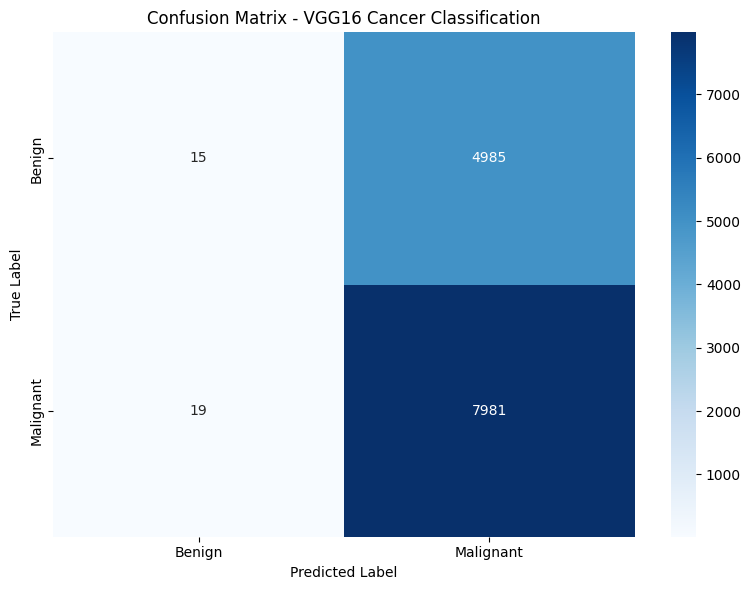

In [12]:
print("\nGenerating Detailed Classification Report...")

# Get predictions
validation_generator.reset()
y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = validation_generator.classes

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - VGG16 Cancer Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")